## Introduction

The goal of this notebook is to test a basic Fed.Learning with Pysyft and Duet. Duet is the mvp of pysyft that allows us to execute P2P remote training using WebRTC protocol. 

We will use a signaling server hosted in AWS:  http://52.19.68.70:5000

**Pre-requirements**:
   - We need to launch a data owner and open a Duet session.
   - We need the data owner to publish its data and make it accesible.

**Steps**:

- *Step 0*. Data scientist connection to Duet Network Session. (2 sessions - one per each DO)
- *Step 1*. Check available data.
- *Step 2*. Describe the data. (federated analytics).
- *Step 3*. Pysyft model definition.
- *Step 4*. Pysyft model training.
- *Step 5*. Retrieve the model.
- *Step 6*. Performance evaluation.



## Step 0. Data Scientist connection to Duet Network Session

In [1]:
import torch

# we create some dicts to store losses
loss_stats = {
    'loss train': [],
    'loss val': []
}

#### DS - Part 2: Join the Duet Server the Data Owner 1 connected to

In [2]:
import syft as sy
duet_1 = sy.duet("cf1430ac7d5b35db8bd5fd8a50d693c3", network_url="http://18.203.84.144:5000")

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://18.203.84.144:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > STEP 1: Send the following Duet Client ID to your duet partner!
♫♫♫ > Duet Client ID: 98727344504f5f876309fb80e8e6c927

♫♫♫ > ...waiting for partner to connect...

♫♫♫ > CONNECTED!


#### DS - Part 2: Join the Duet Server the Data Owner 2 connected to

In [3]:
duet_2 = sy.duet("2e36e02fac6535821560b2b6d80b5d12", network_url="http://18.203.84.144:5000")

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://18.203.84.144:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > STEP 1: Send the following Duet Client ID to your duet partner!
♫♫♫ > Duet Client ID: 2d76797b082c21eff352870a8ac6cca6

♫♫♫ > ...waiting for partner to connect...

♫♫♫ > CONNECTED!


## Step 1. Check available data

In [6]:
duet_1.store.pandas

,ID,Tags,Description,object_type
0,<UID: c112f7e6676a47a5bc83709f0d56ddc3>,[x_data_train_1],X Train 1 - synthetic regression dataset,<class 'torch.Tensor'>
1,<UID: 844f3c37f3a14b0e80743480c59d163b>,[y_data_train_1],Y Train 1 - synthetic regression dataset,<class 'torch.Tensor'>
2,<UID: de79123375ec4f4d90c05d4d293a0263>,[x_data_test],X Test - synthetic regression dataset,<class 'torch.Tensor'>
3,<UID: 7dbff316ccb44e34965ce36a5a5728e3>,[y_data_test],Y Test - synthetic regression dataset,<class 'torch.Tensor'>


In [7]:
duet_2.store.pandas

,ID,Tags,Description,object_type
0,<UID: 9667e5cfdba642a783b22726407fd4c8>,[x_data_train_2],X Train 2 - synthetic regression dataset,<class 'torch.Tensor'>
1,<UID: 1a2bb073df704ec5a28c952f6943c769>,[y_data_train_2],Y Train 2 - synthetic regression dataset,<class 'torch.Tensor'>


Get the pointers to the data

In [8]:
X_train_1_ptr = duet_1.store['x_data_train_1']
Y_train_1_ptr = duet_1.store['y_data_train_1']

X_train_2_ptr = duet_2.store['x_data_train_2']
Y_train_2_ptr = duet_2.store['y_data_train_2']

X_test_ptr = duet_1.store['x_data_test']
Y_test_ptr = duet_1.store['y_data_test']


print(X_train_1_ptr)
print(Y_train_1_ptr)

print(X_test_ptr)
print(Y_test_ptr)

## Step 2. Describe the data

We will try to perform some basic analysis to describe the data in the Data Owner's duet server, without having to share his/her data.

#### Get average and std X 

In [9]:
average_train = X_train_1_ptr.float().mean()
std_train = X_train_1_ptr.float().std()

#### Get average and std Y

In [10]:
average_test = X_test_ptr.float().mean()
std_test = Y_test_ptr.float().std()

Now we want to see the results.

In [15]:
try:
    result = average_test.get()
except Exception as e:
    print(e)

In [14]:
# Looks like the Data Scientist does not have permission to download this result! He/she needs
# to make a request to the Data Owner.
average_test.request(reason="I did some basic analytics (mean and std). Please approve!")

In [16]:
result

tensor(0.5643)

## Step.3. Pysyft Model definition

We are trying to learn the unknown parameters (a,b) y = a*x + b. Thus, we define a model that applies this linear transformation to the training data x in order to predict ŷ. We will use MSE loss to adjust the parameters (a,b) using the y true value

In [17]:
input_size = 1 # input features 
output_size = 1 # output features

In [18]:
class linearRegression(sy.Module):
    def __init__(self, torch_ref):
        super(linearRegression, self).__init__(torch_ref=torch_ref)
        self.linear = torch.nn.Linear(input_size, output_size)

    def forward(self, x):
        out = self.linear(x)
        return out

In [19]:
torch_model = linearRegression(torch)

In [20]:
print(torch_model)

## Step 4. PySyft Model training 

This is the most common implementation of a PySyft model trainer in Duet.

In [21]:
def train(iterations, model, torch_ref, optim, data_ptr, target_ptr):

    losses = []

    for i in range(iterations):

        optim.zero_grad()
        output = model(data_ptr)
        loss = torch_ref.nn.functional.mse_loss(output, target_ptr)
        loss_item = loss.item()

        loss_value = loss_item.get(
            reason="To evaluate training progress",
            request_block=True,
            timeout_secs=5,
        )

        print("Epoch", i, "loss", loss_value)
        losses.append(loss_value)
        loss.backward()
        optim.step()

    return losses

### Training

Train on Data Owner 1 data

In [22]:
remote_model1 = torch_model.send(duet_1)

In [23]:
remote_torch1 = duet_1.torch
params = remote_model1.parameters()
optim1 = remote_torch1.optim.Adam(params=params, lr=0.1)

In [24]:
iteration = 10
losses = train(iteration, remote_model1, remote_torch1, optim1, X_train_1_ptr, Y_train_1_ptr)

Epoch 0 loss 445.2080383300781
Epoch 1 loss 444.95526123046875
Epoch 2 loss 444.7501525878906
Epoch 3 loss 444.5926818847656
Epoch 4 loss 444.4814147949219
Epoch 5 loss 444.4129943847656
Epoch 6 loss 444.3815002441406
Epoch 7 loss 444.3782958984375
Epoch 8 loss 444.3929138183594
Epoch 9 loss 444.41461181640625


Train on Data Owner 2 data

In [25]:
remote_model2 = torch_model.send(duet_2)

In [26]:
remote_torch2 = duet_2.torch
params = remote_model2.parameters()
optim2 = remote_torch2.optim.Adam(params=params, lr=0.1)

In [27]:
iteration = 10
losses = train(iteration, remote_model2, remote_torch2, optim2, X_train_2_ptr, Y_train_2_ptr)

Epoch 0 loss 445.2080383300781
Epoch 1 loss 444.95526123046875
Epoch 2 loss 444.7501525878906
Epoch 3 loss 444.5926818847656
Epoch 4 loss 444.4814147949219
Epoch 5 loss 444.4129943847656


Exception in callback Transaction.__retry()
handle: <TimerHandle when=27895.741074371 Transaction.__retry()>
Traceback (most recent call last):
  File "/home/yolandadelahoz/anaconda3/envs/openmined-courses/lib/python3.9/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/home/yolandadelahoz/anaconda3/envs/openmined-courses/lib/python3.9/site-packages/aioice/stun.py", line 306, in __retry
    self.__future.set_exception(TransactionTimeout())
  File "/home/yolandadelahoz/anaconda3/envs/openmined-courses/lib/python3.9/asyncio/futures.py", line 270, in set_exception
    raise exceptions.InvalidStateError(f'{self._state}: {self!r}')
asyncio.exceptions.InvalidStateError: FINISHED: <Future finished result=(Message(messa...xbaH\xbb\xcb'), ('3.249.185.60', 40960))>


Epoch 6 loss 444.3815002441406
Epoch 7 loss 444.3782958984375
Epoch 8 loss 444.3929138183594
Epoch 9 loss 444.41461181640625


#### Sanity check! remote model parameters vs. base model parameters

In [28]:
param1 = remote_model1.parameters().get(request_block=True)
param2 = remote_model2.parameters().get(request_block=True)

print("Base Model parameters:")
print(torch_model.parameters())
print()

print("Remote model parameters:")
print(param1)
print()

assert(torch_model.parameters()!= param1)

print("Remote model parameters:")
print(param2)
print()

assert(torch_model.parameters()!= param2)

Base Model parameters:
[Parameter containing:
tensor([[-0.9809]], requires_grad=True), Parameter containing:
tensor([0.3665], requires_grad=True)]

Remote model parameters:
[Parameter containing:
tensor([[-0.2943]], requires_grad=True), Parameter containing:
tensor([1.1962], requires_grad=True)]

Remote model parameters:
[Parameter containing:
tensor([[-0.2943]], requires_grad=True), Parameter containing:
tensor([1.1962], requires_grad=True)]



The remote model paramter values are different from the base model paramter values. That means the remote copies of our base model got trained and updated.

## Step 5. Retrieve the model (parameters)

In [29]:
remote_model1_updates = remote_model1.get(
    request_block=True
).state_dict()

print(remote_model1_updates)

OrderedDict([('linear.weight', tensor([[-0.2943]])), ('linear.bias', tensor([1.1962]))])


In [30]:
remote_model2_updates = remote_model2.get(
    request_block=True
).state_dict()

print(remote_model2_updates)

OrderedDict([('linear.weight', tensor([[-0.2943]])), ('linear.bias', tensor([1.1962]))])


### Averaging Model Updates

Ideally, there will be a coordinator server with a secure aggreagtor who will get the model updates from different clients and make an aggregation. For the case of simplicity, in this example we will make the Data Sceintist server work as the coordinator.

In [31]:
from collections import OrderedDict

In [32]:
avg_updates = OrderedDict()
avg_updates["linear.weight"] = (
    remote_model1_updates["linear.weight"] + remote_model2_updates["linear.weight"]
) / 2
avg_updates["linear.bias"] = (
    remote_model1_updates["linear.bias"] + remote_model2_updates["linear.bias"]
) / 2

print(avg_updates)

OrderedDict([('linear.weight', tensor([[-0.2943]])), ('linear.bias', tensor([1.1962]))])


Let's do the aggregation of the weights. In this example, we will just calculate the average of corresponding weights from each model.

In [33]:
final_model = linearRegression(torch)

We instantiate a base model and update the parameters of this base model with the ones retrieve from Duet Data Owner data.

In [34]:
final_model.load_state_dict(avg_updates)

In [35]:
del avg_updates, remote_model1_updates, remote_model2_updates

## Step 6. Performance evaluation

Retrieve test dataset to evaluate the model.

In [36]:
x_test_data = X_test_ptr.get(request_block=True)
y_test_data = Y_test_ptr.get(request_block=True)

In [37]:
x_test_data.shape, y_test_data.shape

(torch.Size([125, 1]), torch.Size([125, 1]))

### Visualization of predicted regression line

In [38]:
syft_preds = final_model(x_test_data)

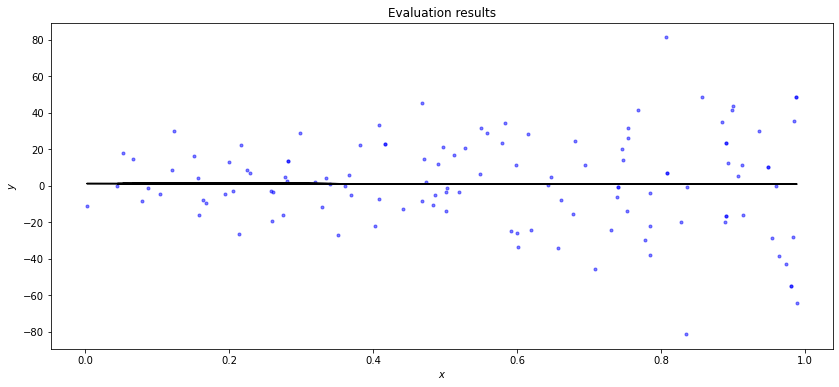

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.title("Evaluation results")
#plt.plot(x_t, y_t, '.', alpha=0.5, color='green' ) 
plt.plot(x_test_data, y_test_data, '.', alpha=0.5, color='blue' ) 
plt.plot(x_test_data, syft_preds.detach().numpy(), color='black' ) 
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.show()

## Available functions in Pysyft

In [40]:
duet_1.torch

Module:
	.Tensor -> <syft.ast.klass.Class object at 0x7fb29666f5e0>
	.BFloat16Tensor -> <syft.ast.klass.Class object at 0x7fb29666f640>
	.BoolTensor -> <syft.ast.klass.Class object at 0x7fb29666f6a0>
	.ByteTensor -> <syft.ast.klass.Class object at 0x7fb29666f700>
	.CharTensor -> <syft.ast.klass.Class object at 0x7fb29666f760>
	.DoubleTensor -> <syft.ast.klass.Class object at 0x7fb29666f7c0>
	.FloatTensor -> <syft.ast.klass.Class object at 0x7fb29666f820>
	.HalfTensor -> <syft.ast.klass.Class object at 0x7fb29666f880>
	.IntTensor -> <syft.ast.klass.Class object at 0x7fb29666f8e0>
	.LongTensor -> <syft.ast.klass.Class object at 0x7fb29666f940>
	.ShortTensor -> <syft.ast.klass.Class object at 0x7fb29666f9a0>
	.nn -> Module:
		.Parameter -> <syft.ast.klass.Class object at 0x7fb29666fac0>
		.Module -> <syft.ast.klass.Class object at 0x7fb2965c1100>
		.Conv2d -> <syft.ast.klass.Class object at 0x7fb2965c15e0>
		.Dropout2d -> <syft.ast.klass.Class object at 0x7fb2965c1a00>
		.Linear -> <syft.

## Conclusions

*Advantages*

 - Easy to use
 - Federated Analytics
 - FL Machine Learning
 - Privacy pre-serving mechanisms
 - Programmatic access control in a operational level (API).
 

*Disadvantages*

* NO Data discovery: 
    * We need to know that the data owner before hand.
    * We don't have a global data catalog.
    * We can not persist data in disk.
* Communication:
    * Peer-to-peer sessions: We need to open a new session with each Data Owner.
    * We need the simultaneaous connection of both: data scientist and data owner.
* NO (secure) logging and monitoring
* NO support for Tensorflow

## Future steps

Pysyft features to be tested:

* Federated Algorithms: aggregation and coordination schemas.
* Test with more complex ML models: CNN, LSMT....
* NLP
    * [Privacy preserving NLP](https://github.com/OpenMined/SyferText)
    * [Private information retrieval](https://github.com/OpenMined/PIR)
* SplitNN
* [Vertical federated learning](https://github.com/OpenMined/PyVertical)
* [Private set intersection](https://github.com/OpenMined/PSI)
* Try support with scikit-learn
* Differential privacy:
    - https://github.com/OpenMined/PipelineDP
    - https://github.com/OpenMined/PyDP
* [Homomorphic encryption](https://github.com/OpenMined/TenSEAL)
* [SMPC](https://github.com/OpenMined/SyMPC)
* Blockchain
    * Monitoring and logging
    * [Data poisoning](https://github.com/OpenMined/PyAriesFL)
